<a href="https://colab.research.google.com/github/KavindaKGD/DL_Final_Assignment/blob/dev%2FMigara/LSTM_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
!nvidia-smi

Tue Oct  7 05:37:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P0             26W /   70W |     202MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [55]:
# Basic libraries
import os, glob, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
# Deep learning
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.metrics import classification_report, confusion_matrix

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
!unzip -q "/content/drive/MyDrive/street_building_dataset.zip" -d "/content/dataset"

replace /content/dataset/street_building_dataset/test/buildings/20057.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [59]:
import os
for root, dirs, files in os.walk("/content/dataset/street_building_dataset"):
    print(root, "->", len(files), "files")

/content/dataset/street_building_dataset -> 0 files
/content/dataset/street_building_dataset/test -> 0 files
/content/dataset/street_building_dataset/test/streets -> 501 files
/content/dataset/street_building_dataset/test/buildings -> 437 files
/content/dataset/street_building_dataset/train -> 0 files
/content/dataset/street_building_dataset/train/streets -> 2382 files
/content/dataset/street_building_dataset/train/buildings -> 2191 files


In [60]:
DATA_ROOT = "/content/dataset/street_building_dataset"

In [61]:
IMG_H, IMG_W = 150, 150
BATCH_SIZE = 32

In [62]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/street_building_dataset/train",
    labels="inferred",
    label_mode="int",
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/street_building_dataset/test",
    labels="inferred",
    label_mode="int",
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 4573 files belonging to 2 classes.
Found 938 files belonging to 2 classes.
Classes: ['buildings', 'streets']


In [63]:
AUTOTUNE = tf.data.AUTOTUNE

def rgb_to_seq(images, labels):
    images = tf.image.rgb_to_grayscale(images)
    images = tf.cast(images, tf.float32) / 255.0
    images = tf.squeeze(images, axis=-1)  # (batch, H, W)
    return images, labels

train_ds = train_ds.map(rgb_to_seq, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
test_ds = test_ds.map(rgb_to_seq, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

In [64]:
from tensorflow.keras import layers, models, Input

timesteps = IMG_H
features = IMG_W

inputs = Input(shape=(timesteps, features))
x = layers.LSTM(128)(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       142,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,169 (590.50 KB)

 Trainable params: 151,169 (590.50 KB)

 Non-trainable params: 0 (0.00 B)

In [124]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_lstm.h5", monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
139/143 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5991 - loss: 0.6645 

143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5977 - loss: 0.6652 - val_accuracy: 0.5394 - val_loss: 0.6888
Epoch 2/20
139/143 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5308 - loss: 0.6893

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5313 - loss: 0.6892 - val_accuracy: 0.5426 - val_loss: 0.6857
Epoch 3/20
140/143 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5712 - loss: 0.6817

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5710 - loss: 0.6818 - val_accuracy: 0.5533 - val_loss: 0.6838
Epoch 4/20
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5702 - loss: 0.6773

143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5705 - loss: 0.6772 - val_accuracy: 0.6418 - val_loss: 0.6408
Epoch 5/20
138/143 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6419 - loss: 0.6436

143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6414 - loss: 0.6440 - val_accuracy: 0.6588 - val_loss: 0.6294
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6182 - loss: 0.6512 - val_accuracy: 0.6226 - val_loss: 0.6401
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5670 - loss: 0.6734 - val_accuracy: 0.5853 - val_loss: 0.6749
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5817 - loss: 0.6681 - val_accuracy: 0.6290 - val_loss: 0.6423


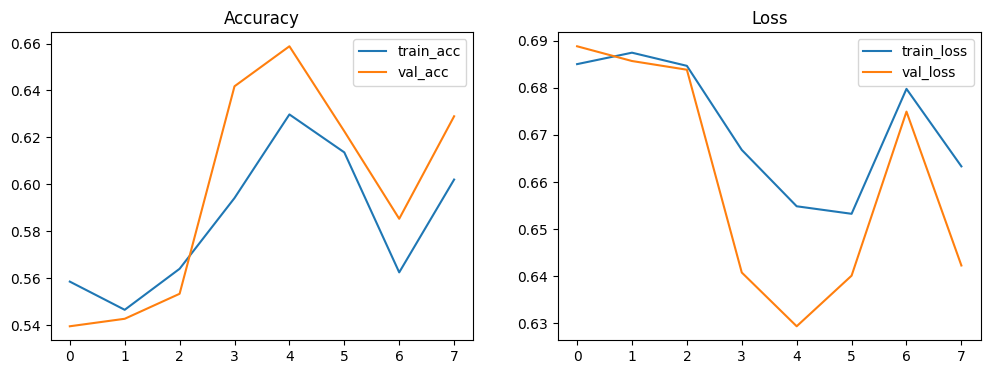

In [125]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.show()

In [126]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.3f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6343 - loss: 0.6520
Test Accuracy: 0.659


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

     streets       0.64      0.60      0.62       437
   buildings       0.67      0.71      0.69       501

    accuracy                           0.66       938
   macro avg       0.66      0.65      0.66       938
weighted avg       0.66      0.66      0.66       938



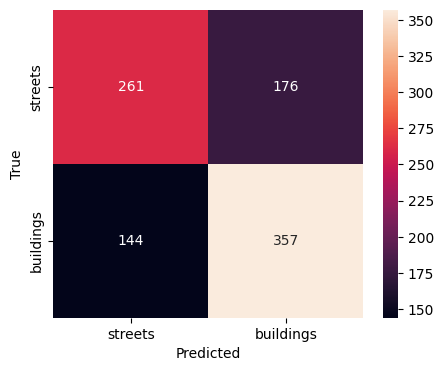

In [127]:
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_prob = model.predict(test_ds)
y_pred = (y_prob.flatten() >= 0.5).astype(int)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

In [128]:
model.save("/content/drive/MyDrive/best_lstm_street_building.keras")

In [82]:
!unzip -q "/content/dataset/pred.zip" -d "/content/dataset/pred"

replace /content/dataset/pred/pred/10004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [129]:
pred_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/pred/pred",
    labels=None,              # unlabeled
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    shuffle=False
)

pred_ds = pred_ds.map(lambda x: tf.image.rgb_to_grayscale(x)/255.0).cache()

Found 7301 files.


In [130]:
pred_prob = model.predict(pred_ds)
pred_class = (pred_prob.flatten() >= 0.5).astype(int)  # 0 = first class, 1 = second class

# Convert numeric predictions to class names
pred_labels = [class_names[i] if i < len(class_names) else "unknown" for i in pred_class]

for i, label in enumerate(pred_labels[:50]):  # show first 50
    print(f"Image {i+1}: {label}")

229/229 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
Image 1: streets
Image 2: streets
Image 3: streets
Image 4: streets
Image 5: streets
Image 6: buildings
Image 7: streets
Image 8: buildings
Image 9: streets
Image 10: streets
Image 11: buildings
Image 12: streets
Image 13: streets
Image 14: streets
Image 15: streets
Image 16: streets
Image 17: streets
Image 18: streets
Image 19: streets
Image 20: streets
Image 21: buildings
Image 22: buildings
Image 23: buildings
Image 24: buildings
Image 25: buildings
Image 26: buildings
Image 27: buildings
Image 28: streets
Image 29: buildings
Image 30: streets
Image 31: streets
Image 32: buildings
Image 33: buildings
Image 34: streets
Image 35: buildings
Image 36: streets
Image 37: streets
Image 38: buildings
Image 39: streets
Image 40: streets
Image 41: streets
Image 42: streets
Image 43: streets
Image 44: streets
Image 45: streets
Image 46: buildings
Image 47: streets
Image 48: buildings
Image 49: buildings
Image 50: streets


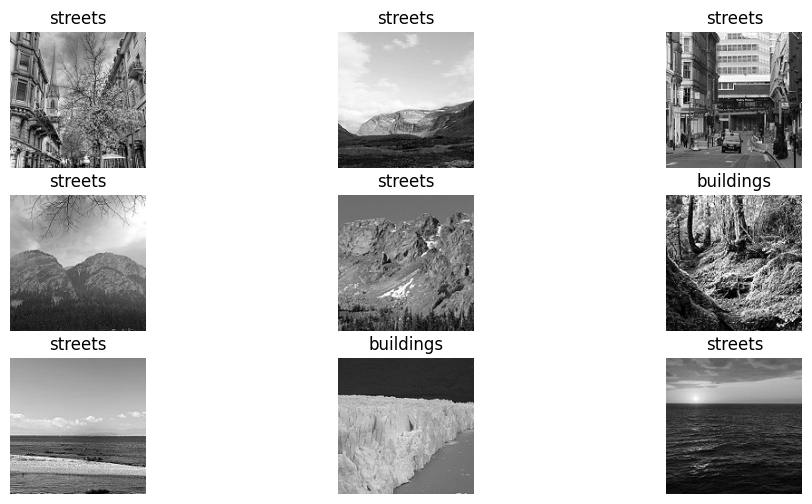

In [131]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for images in pred_ds.take(1):
    imgs = images.numpy()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(pred_labels[i])
    plt.axis('off')
plt.show()

In [122]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

IMG_H, IMG_W = 150, 150
class_names = ['streets', 'buildings']

def predict_image(image_path):
    # Load and preprocess image
    img = load_img(image_path, target_size=(IMG_H, IMG_W))
    img_array = img_to_array(img)
    img_array = tf.image.rgb_to_grayscale(img_array)
    img_array = img_array / 255.0
    img_array = tf.expand_dims(img_array, axis=0)  # add batch dimension

    # Predict
    pred_prob = model.predict(img_array)[0][0]
    pred_class = 1 if pred_prob >= 0.5 else 0
    print(f"Predicted class: {class_names[pred_class]} (probability: {pred_prob:.3f})")

# Example usage:
predict_image("/content/dataset/pred/pred/672.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted class: buildings (probability: 0.532)
